In [ ]:
import numpy as np
import scipy.stats
from functools import partial
# ! pip install emcee
# ! pip install cvxopt
# import emcee
# from cvxopt import matrix, solvers
import pandas as pd
import seaborn as sns
# from multiprocessing import Pool
from scipy import stats
# from numba import jit
import matplotlib.pyplot as plt
from tqdm import tqdm


# !pip install scipy --upgrade
# pool=Pool(4)

In [ ]:
# ! wget http://www.mit.edu/~brendana/dataset.csv

# Utilities

In [ ]:
def gaussian_dist_sqrt(x,params):
  mu,sigma=params
  return np.sqrt(np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi)))

def gaussian_dist(x,mu,sigma):
  return np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

In [ ]:
def norm_innerproduct(a_mu, a_sigma, b_pdf, N=1000): # For gaussian and arbitrary distribution
  # draw N samples
  x = a_mu + np.random.randn(N, 1) * a_sigma

  a_pdf_vec = gaussian_dist_sqrt(x,(a_mu,a_sigma))
  b_pdf_vec = np.vectorize(b_pdf)

  ip_ab = np.average(b_pdf_vec(x) / a_pdf_vec)
  # return (1 - 1e-8) if ip_ab > 1 else ip_ab
  return ip_ab

def norm_innerproduct_closed(h_mu, h_sigma, phi_mu, phi_sigma, N=50000): # For two gaussians
  # draw N samples from h^2
  x = h_mu + np.random.randn(N, 1) * h_sigma

  # take phi / h
  # h_pdf = np.sqrt(np.exp(-(x - h_mu)**2 / (2 * h_sigma**2)) / (h_sigma * np.sqrt(2 * np.pi)))
  # phi_pdf = np.sqrt(np.exp(-(x - phi_mu)**2 / (2 * phi_sigma**2)) / (phi_sigma * np.sqrt(2 * np.pi)))

  h_pdf=gaussian_dist_sqrt(x,(h_mu,h_sigma))
  phi_pdf=gaussian_dist_sqrt(x,(phi_mu,phi_sigma))

  # exp [ phi / h ]
  ip_ab = np.average(phi_pdf / h_pdf)
  return ip_ab

# UBVI

In [ ]:
def norm_ip_hg(weights,h_mu,h_sigma,gs,n): # Inner product between h and gbar
  if n==1: return 0
  return np.dot(weights,np.array([norm_innerproduct_closed(h_mu,h_sigma,gs[i][0],gs[i][1]) for i in range(1,n)]))

def norm_ip_fg(weights,f,gs,n): # Inner product between f and gbar
  if n==1: return 0
  return np.dot(weights,np.array([norm_innerproduct(gs[i][0],gs[i][1],f) for i in range(1,n)]))

In [ ]:
# Exponential Family Tools
def eta(mu,sigma):
  return np.array([mu/sigma**2,-1/(2*sigma**2)])

def A(eta):
  # print(eta)
  eta1,eta2=eta
  return -eta1**2/(4*eta2)+0.5*np.log(abs(1/(2*eta2)))

In [ ]:
def component_objective(theta,f,n, ip_fg,weights,gs): # Finds next component
  mu,sigma=theta

  ip_fh=norm_innerproduct(mu,sigma,f)
  ip_hg = norm_ip_hg(weights,mu,sigma,gs,n)

  numerator=ip_fh-ip_fg*ip_hg
  denom=np.sqrt(1-ip_hg**2)

  return -numerator/denom # Return negative since optimizer is over min

In [ ]:
def ubvi2(p, H, N):
  # f \propto sqrt(p)
  f = lambda x: np.sqrt(p(x))

  gbar = [(lambda x: 0) for i in range(N+1)]
  gs = [(0,1) for i in range(N+1)] #(mean,var)

  lambdas = np.zeros((N, N))

  Z = np.zeros((N, N))
  d = np.zeros(N)

  for n in range(1, N+1):
    print('====STEP %d====' % n)
    # h_opt = [mu, sigma]
    # prev_ip = np.sum([lambdas[n-2,i-1]*norm_innerproduct(gs[i][0],gs[i][1],f) for i in range(1,n)]) if n>1 else 0
    ip_fg=norm_ip_fg(lambdas[n-2,:n-1],f,gs,n)
    # print('prev_ip', ip_fg)
    h_opt = np.array([3*np.random.randn(), np.random.gamma(1, scale=0.1)])
    # h_opt = np.array([np.random.normal(0, 3), np.random.gamma(1)])
    # print('h_opt init', h_opt)
    # h_opt = scipy.optimize.minimize(lambda x: -component_objective2(f, gbar, n, x[0], x[1],prev_ip), h_opt,
                                                #  method='SLSQP', bounds=((None,None),(1e-8,None)))
    # x0 = scipy.optimize.brute(partial(component_objective2,f=f,n=n,ip_fg=ip_fg,weights=lambdas[n-2,:n-1],gs=gs), ((-2, 8), (1e-3, 6)),
    #                                             disp=True, Ns=10, finish=None, workers=-1)

    x0_res=scipy.optimize.minimize(partial(component_objective,f=f,n=n,ip_fg=ip_fg,weights=lambdas[n-2,:n-1],gs=gs),h_opt,method='Powell',bounds=((None,None),(0,None)), options={'disp':False})
    x0 = x0_res.x
    
    # PRECOMPUTE X
    

    # ,bounds=[(None,None),(0,None)]
    # print('h_opt post', h_opt)
    # print('h_opt', h_opt)
    # print('x0',x0)
    gs[n]=(x0[0], x0[1])
    # print('step', n, x0[0], x0[1])
    # print('gs',gs)

    for i in range(1, n+1):
      # <g_n, g_i>
      # print('<g_n,g_i>', gs[n], gs[i])
      etan=eta(gs[n][0], gs[n][1])
      etai=eta(gs[i][0], gs[i][1])
      Z[i-1,n-1]=np.exp(A((etan+etai)/2)-np.mean([A(etai),A(etan)]))
      # print("Z",Z)
      # Z[n-1, i-1] = norm_innerproduct_closed(gs[n][0], gs[n][1], gs[i][0], gs[i][1])
      # Z[n-1, i-1] = norm_innerproduct(gs[n][0],gs[n][1], lambda x: np.sqrt(scipy.stats.norm(gs[i][0],gs[i][1]).pdf(x)))
      Z[n-1, i-1] = Z[i-1, n-1]
      # print("Z",Z)

    # update weights using eq 7
    d[n-1]=norm_innerproduct(gs[n][0],gs[n][1],f)
    opt_d=d[:n]/np.max(d[:n])

    # optimize betas wrt fun
    # print(Z)
    # print('Z[:n,:n]', Z[:n,:n])
    Zinv = np.linalg.pinv(Z[:n,:n])
    # print("Minimal Eigenvalue of Z",np.linalg.eigvalsh(Z[:n,:n]).min())

    Linv=np.linalg.inv(np.linalg.cholesky(Z[:n,:n]))

    # print(Zinv.shape, d.shape, np.zeros(n).shape)
     # quadratic programming optimization https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf
    # P=matrix(2*Zinv, tc='d')
    # q=matrix(2*Zinv@d[:n,np.newaxis],tc='d')
    # G=matrix(-1*np.eye(n), tc='d')
    # h=matrix(np.zeros(n),tc='d')
    # sol=solvers.qp(P,q,G,h)
    # beta=np.array(sol['x'])

    # sometimes beta finding fails, and if so, let's run it again
    # fun = lambda b: b @ Zinv @ b[:,np.newaxis] + 2 * b @ Zinv @ d[:n,np.newaxis]

    # constr_pos_sqrt = lambda b: np.array((b + d[:n,np.newaxis]).T @ Zinv @ (b + d[:n,np.newaxis]))
    # beta = scipy.optimize.minimize(fun, np.zeros(n),
    #                                method='SLSQP', bounds=((0,None),)*n)
    # print(Linv@d[:n,np.newaxis])
    beta=scipy.optimize.nnls(Linv,-np.dot(Linv,opt_d))[0]
    # beta = scipy.optimize.differential_evolution(fun, ((0,1),)*n,
                                                #  constraints=(scipy.optimize.NonlinearConstraint(constr_pos_sqrt, 0, np.inf)))
    # print('beta', beta)
    # beta = beta.x
    # beta=beta[:,np.newaxis]
    # print(beta)

    # for i in range(1, n+1):
      # print('40', (beta + d)[np.newaxis] @ Zinv @ (beta + d).shape, (beta + d)[np.newaxis].shape, Zinv.shape)

    # print(((Zinv @ (beta + d)) / np.sqrt((beta + d).T @ Zinv @ (beta + d))).shape)
    # print('Z-1', Zinv)
    # print('beta', beta)
    # print('d', opt_d)
    sqrt = np.dot(np.dot(beta + opt_d, Zinv) , beta + opt_d)
    # print('sqrt', sqrt)

    lambdas[n-1,:n] = (np.dot(Zinv, (beta + opt_d)) / np.sqrt(sqrt)).reshape(1,n)
    # print('lambdas', lambdas[n-1,:n])
    # print('------------------------------')

    gbar[n]=lambda x: np.dot(lambdas[n-1,:n],np.array([gaussian_dist_sqrt(x,gs[i]) for i in range(1,n+1)]))
    
    # gbar[n] = lambda x: sum([lambdas[n-1, i-1] * scipy.stats.norm(gs[i][0],gs[i][1]).pdf(x) for i in range(1, n+1)])

    # return lambda x: gbar[n](x)**2

  # print('lambdas fin', lambdas)
  return lambda x: gbar[N](x)**2

# Experiments

In [ ]:
# test_p = lambda x: (scipy.stats.norm(1).pdf(x) + scipy.stats.norm(5, 2).pdf(x))/2
n=5
comps=[]
mu=5*np.random.randn(n)
sigma=3*np.random.gamma(1,1,n)

# test_p = lambda x: 0.5*gaussian_dist(x,0,1)+0.5*gaussian_dist(x,7,1)
test_p=lambda x: np.sum([1/n*gaussian_dist(x,mu[i],sigma[i]) for i in range(n)])

In [ ]:
test_p(2)

0.05505767616439471

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


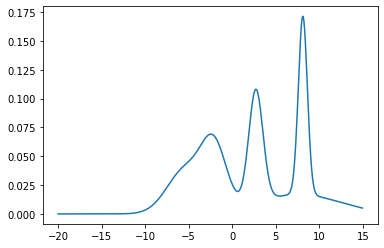

In [ ]:
X = np.arange(-20, 15, step=0.05)
sns.lineplot(X, [test_p(x).item() for x in X])

In [ ]:
# q = ubvi2(test_p, None, 1)
q = ubvi2(test_p, None, 20)

====STEP 1====
====STEP 2====
====STEP 3====
====STEP 4====
====STEP 5====
====STEP 6====
====STEP 7====
====STEP 8====
====STEP 9====
====STEP 10====
====STEP 11====
====STEP 12====
====STEP 13====
====STEP 14====
====STEP 15====
====STEP 16====
====STEP 17====
====STEP 18====
====STEP 19====
====STEP 20====


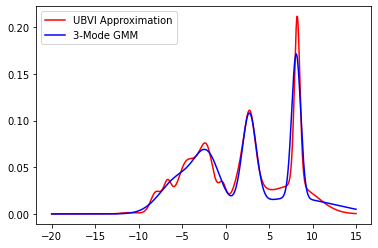

In [ ]:
fig, ax = plt.subplots()
X = np.arange(-20, 15, step=0.01)
ax.plot(X, [q(x) for x in X],c='r',label="UBVI Approximation")
ax.plot(X, [test_p(x) for x in X],c='b', label="3-Mode GMM")
ax.legend()
plt.show()

In [ ]:
a=np.array([[1.,         0.97493371, 0.99999999],
 [0.97493371, 1.,         0.94826202],
 [0.99999999, 0.94826202, 1.        ]])
a.dtype

dtype('float64')

In [ ]:
output_df = pd.DataFrame({'x': X, 'p': [test_p(x) for x in X], 'q': [q(x) for x in X]})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


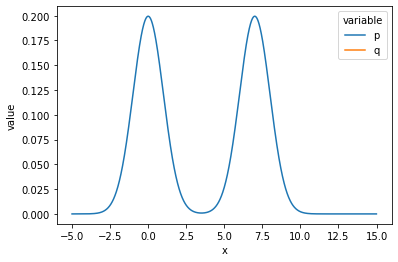

In [ ]:
sns.lineplot(hue='variable', y='value', x='x', data=pd.melt(output_df, ['x']))

# Cauchy


In [ ]:
cauchy_pdf=lambda x: 1/(np.pi*(1+x**2))


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


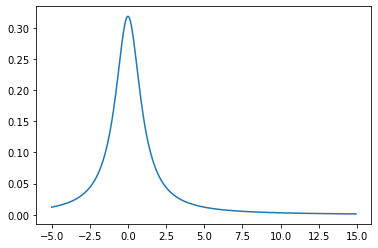

In [ ]:
X = np.arange(-5, 15, step=0.05)
sns.lineplot(X, [cauchy_pdf(x) for x in X])

In [ ]:
cauchy_q=ubvi2(cauchy_pdf,None,6)

====STEP 1====
prev_ip 0
   direc: array([[ 1.        ,  0.        ],
       [ 0.11335191, -0.21044003]])
     fun: -0.9318681784174494
 message: 'Optimization terminated successfully.'
    nfev: 91
     nit: 2
  status: 0
 success: True
       x: array([-0.15231039,  1.58645051])
h_opt [0.65803651 0.01013959]
x0 [-0.15231039  1.58645051]
step 1 -0.15231038910481773 1.5864505112981815
gs [(0, 1), (-0.15231038910481773, 1.5864505112981815), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]
Z[:n,:n] [[1.]]
beta [0.]
d [1.]
sqrt 1.0
lambdas [1.]
------------------------------
====STEP 2====
prev_ip 0.9262390728052439
   direc: array([[1., 0.],
       [0., 1.]])
     fun: -0.0995060367002931
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 2
  status: 0
 success: True
       x: array([-0.2567192 ,  0.55180005])
h_opt [0.39892228 0.14760651]
x0 [-0.2567192   0.55180005]
step 2 -0.2567192021615863 0.5518000512406969
gs [(0, 1), (-0.15231038910481773, 1.5864505112981815), (-0.25

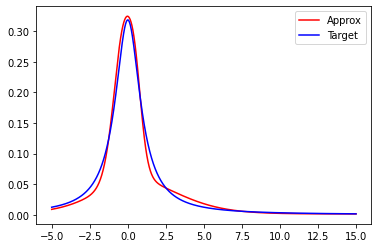

In [ ]:
fig, ax = plt.subplots()
X = np.arange(-5, 15, step=0.01)
ax.plot(X, [cauchy_q(x) for x in X],c='r',label="Approx")
ax.plot(X, [cauchy_pdf(x) for x in X],c='b', label="Target")
ax.legend()

# Running on Birmingham Parking Dataset

In [ ]:
df = pd.read_csv('dataset.csv')
df['LastUpdated'] = pd.to_datetime(df['LastUpdated'])
df['%'] = df['Occupancy'] / df['Capacity']

lot_list = list(df['SystemCodeNumber'].unique())

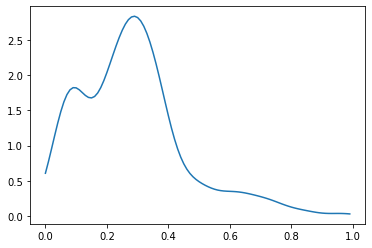

In [ ]:
fs = [stats.gaussian_kde(df.loc[df['SystemCodeNumber'] == lot_list[i], '%'].values) for i in range(len(lot_list))]

sns.lineplot(x=np.arange(0, 1, 0.01), y=np.array([fs[0](x) for x in list(np.arange(0, 1, 0.01))]).flatten())

In [ ]:
qs = [ubvi2(fs[i], None, 3) for i in tqdm(range(len(lot_list)))]

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  if meth not in ('newton-cg', 'dogleg', 'trust-ncg', 'trust-constr',


====STEP 1====
prev_ip 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


   direc: array([[1., 0.],
       [0., 1.]])
     fun: -0.359733233559269
 message: 'Optimization terminated successfully.'
    nfev: 164
     nit: 6
  status: 0
 success: True
       x: array([2.03672663, 2.26060727])
h_opt [0.34671699 0.11294244]
x0 [2.03672663 2.26060727]
step 1 2.036726627234896 2.260607271118102
gs [(0, 1), (2.036726627234896, 2.260607271118102), (0, 1), (0, 1)]
Z[:n,:n] [[1.]]
Minimal Eigenvalue of Z 1.0
beta      fun: 0.0
     jac: array([0.53494198])
 message: 'Optimization terminated successfully.'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.])
[[0.]]
Z-1 [[1.]]
beta [[0.]]
d [[0.26747098]]
sqrt [[0.07154073]]
lambdas [1.]
------------------------------
====STEP 2====
prev_ip 0.2698876372331067
   direc: array([[ 1.        ,  0.        ],
       [-0.04884379,  0.04962227]])
     fun: -0.9234410687822796
 message: 'Optimization terminated successfully.'
    nfev: 150
     nit: 3
  status: 0
 success: True
       x: array([0

  3%|▎         | 1/30 [00:30<14:41, 30.41s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 53
     nit: 2
  status: 3
 success: False
       x: array([ 2.56735273, -0.38312177])
h_opt [0.97942375 0.20523292]
x0 [ 2.56735273 -0.38312177]
step 3 2.567352730983869 -0.3831217706413792
gs [(0, 1), (2.036726627234896, 2.260607271118102), (0.3718693800854076, 0.17660045449440356), (2.567352730983869, -0.3831217706413792)]
Z[:n,:n] [[1.00000000e+00 3.44386555e-01 5.66378388e-01]
 [3.44386555e-01 1.00000000e+00 9.99754776e-04]
 [5.66378388e-01 9.99754776e-04 1.00000000e+00]]
Minimal Eigenvalue of Z 0.3375810919327599
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 1.78252168 -0.61286778 -1.00896904]
 [-0.61286778  1.2107176   0.34590464]
 [-1.00896904  0.34590464  1.57111244]]
beta [[0.]
 [0.]
 [0.]]
d [[0.26747

  7%|▋         | 2/30 [00:50<12:41, 27.21s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([3.20225079, 2.63552831])
h_opt [0.61432182 0.04759935]
x0 [3.20225079 2.63552831]
step 3 3.202250786238922 2.635528311254553
gs [(0, 1), (-7.701697006380727, -2.4159885232459857), (2.6385436426383397, 2.7190030936001595), (3.202250786238922, 2.635528311254553)]
Z[:n,:n] [[1.         0.13213852 0.09757205]
 [0.13213852 1.         0.99423342]
 [0.09757205 0.99423342 1.        ]]
Minimal Eigenvalue of Z 0.0051579509550484836
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[  1.13228522  -3.45882529   3.3284003 ]
 [ -3.45882529  97.52294829 -96.62308937]
 [  3.3284003  -96.62308937  96.74114541]]
beta [[0.]
 [0.]
 [0.]]
d [[       nan]
 [0.33477908]
 [0.2712420

 10%|█         | 3/30 [01:55<17:24, 38.68s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([3.28296638, 2.63687297])
h_opt [0.69503742 0.048944  ]
x0 [3.28296638 2.63687297]
step 3 3.282966380610967 2.6368729655860306
gs [(0, 1), (3.7076446602582154, -0.14385384437368076), (2.644451590965937, 2.614950889836555), (3.282966380610967, 2.6368729655860306)]
Z[:n,:n] [[1.         0.31782915 0.32770114]
 [0.31782915 1.         0.99261927]
 [0.32770114 0.99261927 1.        ]]
Minimal Eigenvalue of Z 0.007325834682156698
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[  1.12506857   0.57017119  -0.93464916]
 [  0.57017119  68.28389829 -67.96675932]
 [ -0.93464916 -67.96675932  68.77140091]]
beta [[0.]
 [0.]
 [0.]]
d [[       nan]
 [0.30070656]
 [0.2825596

 13%|█▎        | 4/30 [02:43<17:54, 41.34s/it]

   direc: array([[0.9825372 , 0.19532598],
       [0.45029681, 0.13546414]])
     fun: -2.709576684190996e-10
 message: 'Optimization terminated successfully.'
    nfev: 194
     nit: 4
  status: 0
 success: True
       x: array([9.13256371, 1.46822162])
h_opt [0.57916337 0.08377304]
x0 [9.13256371 1.46822162]
step 3 9.132563710002492 1.4682216172260194
gs [(0, 1), (3.3397635956687455, 6.021238288880495), (0.740953764491137, 0.20432087120776043), (9.132563710002492, 1.4682216172260194)]
Z[:n,:n] [[1.00000000e+00 2.48528507e-01 5.45348478e-01]
 [2.48528507e-01 1.00000000e+00 1.73274045e-04]
 [5.45348478e-01 1.73274045e-04 1.00000000e+00]]
Minimal Eigenvalue of Z 0.40075628499789484
beta      fun: -0.0041327209112326175
     jac: array([ 1.48429535e-08,  1.92607385e+00, -3.33712262e-04])
 message: 'Optimization terminated successfully.'
    nfev: 11
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([5.14641587e-02, 2.84605955e-16, 1.15621169e-16])
[[5.14641587e-02]
 [2.8

 17%|█▋        | 5/30 [03:00<14:14, 34.17s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([2.7966741, 2.6761418])
h_opt [0.20874514 0.08821284]
x0 [2.7966741 2.6761418]
step 3 2.7966741041032814 2.676141799656331
gs [(0, 1), (0.6408953979942574, 0.29143093108562257), (12.674560058836606, -0.397046896185681), (2.7966741041032814, 2.676141799656331)]
Z[:n,:n] [[1.00000000e+00 1.49918024e-65 3.95219673e-01]
 [1.49918024e-65 1.00000000e+00 1.92348408e-02]
 [3.95219673e-01 1.92348408e-02 1.00000000e+00]]
Minimal Eigenvalue of Z 0.6043125364265296
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 1.18519418  0.00901317 -0.46858542]
 [ 0.00901317  1.00043866 -0.02280546]
 [-0.46858542 -0.02280546  1.18563284]]
beta [[0.]
 [0.]
 [0.]]
d [[0.95684872]
 [ 

 20%|██        | 6/30 [03:17<11:39, 29.14s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 60
     nit: 2
  status: 3
 success: False
       x: array([ 3.58398125, -0.50807481])
h_opt [0.974638   0.08027988]
x0 [ 3.58398125 -0.50807481]
step 3 3.5839812509227835 -0.5080748058635183
gs [(0, 1), (0.4736965131381594, 0.2941688506645486), (278.85469271374, 29.488371680575284), (3.5839812509227835, -0.5080748058635183)]
Z[:n,:n] [[1.00000000e+00 2.98397010e-11 8.35175146e-04]
 [2.98397010e-11 1.00000000e+00 6.46059502e-11]
 [8.35175146e-04 6.46059502e-11 1.00000000e+00]]
Minimal Eigenvalue of Z 0.9991648248538676
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 1.00000070e+00 -2.97857959e-11 -8.35175729e-04]
 [-2.97857002e-11  1.00000000e+00 -6.45810829e-11]
 [-8.35175729e-04 -6.45802985e-11  1.00000070e+00]]

 23%|██▎       | 7/30 [03:35<09:48, 25.61s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([3.45763451, 2.59983145])
h_opt [0.86970555 0.01190249]
x0 [3.45763451 2.59983145]
step 3 3.4576345101258057 2.5998314523407227
gs [(0, 1), (4.630838977951215, 4.049006651859689), (2.861751036287883, -0.36204120775830595), (3.4576345101258057, 2.5998314523407227)]
Z[:n,:n] [[1.         0.40172462 0.93950352]
 [0.40172462 1.         0.51600697]
 [0.93950352 0.51600697 1.        ]]
Minimal Eigenvalue of Z 0.05149494822241267
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 9.26532226  1.04891958 -9.24605271]
 [ 1.04891958  1.48163385 -1.74999703]
 [-9.24605271 -1.74999703 10.58970975]]
beta [[0.]
 [0.]
 [0.]]
d [[0.17376869]
 [       nan]
 [0.22372956]]
sqrt 

 27%|██▋       | 8/30 [03:59<09:10, 25.02s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 54
     nit: 2
  status: 3
 success: False
       x: array([ 3.36119644, -0.53475104])
h_opt [0.56699431 0.05360365]
x0 [ 3.36119644 -0.53475104]
step 3 3.361196436452366 -0.5347510392164139
gs [(0, 1), (3.2941111485578674, 3.369224583339154), (-2995.4924601222983, 29.245040970669503), (3.361196436452366, -0.5347510392164139)]
Z[:n,:n] [[1.         0.         0.55639278]
 [0.         1.         0.        ]
 [0.55639278 0.         1.        ]]
Minimal Eigenvalue of Z 0.44360722496873706
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 1.44837888  0.         -0.80586754]
 [ 0.          1.          0.        ]
 [-0.80586754  0.          1.44837888]]
beta [[0.]
 [0.]
 [0.]]
d [[0.05859647]
 [0.        ]
 [       nan]]


 30%|███       | 9/30 [05:50<17:51, 51.01s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([3.15170336, 2.63618797])
h_opt [0.5637744  0.04825901]
x0 [3.15170336 2.63618797]
step 3 3.1517033630777274 2.63618797360897
gs [(0, 1), (4.686028155076407, 5.111697210988615), (3.3781986268219586, -0.4595991321953399), (3.1517033630777274, 2.63618797360897)]
Z[:n,:n] [[1.         0.4155502  0.88671294]
 [0.4155502  1.         0.58067972]
 [0.88671294 0.58067972 1.        ]]
Minimal Eigenvalue of Z 0.09170888914883038
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 5.02892639  0.75376501 -4.89691015]
 [ 0.75376501  1.62170429 -1.61006397]
 [-4.89691015 -1.61006397  6.27708509]]
beta [[0.]
 [0.]
 [0.]]
d [[0.24851843]
 [       nan]
 [0.32586934]]
sqrt [[na

 33%|███▎      | 10/30 [08:19<26:49, 80.49s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([2.89643027, 2.61280938])
h_opt [0.30850131 0.02488042]
x0 [2.89643027 2.61280938]
step 3 2.896430268847204 2.6128093793127167
gs [(0, 1), (0.6407125783254201, 0.34640105540234734), (2.705495682962302, -0.40215727138442703), (2.896430268847204, 2.6128093793127167)]
Z[:n,:n] [[1.         0.02262283 0.42505072]
 [0.02262283 1.         0.54765664]
 [0.42505072 0.54765664 1.        ]]
Minimal Eigenvalue of Z 0.31759729326009484
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 1.32232638  0.39695736 -0.7794521 ]
 [ 0.39695736  1.54758917 -1.01627448]
 [-0.7794521  -1.01627448  1.88787614]]
beta [[0.]
 [0.]
 [0.]]
d [[0.88426128]
 [       nan]
 [0.3114231 ]]
sqrt

 37%|███▋      | 11/30 [08:41<19:51, 62.72s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([2.83062888, 2.60950769])
h_opt [0.24269991 0.02157873]
x0 [2.83062888 2.60950769]
step 3 2.830628876519362 2.6095076890454854
gs [(0, 1), (0.6526152238528196, 0.17291605730340562), (3.466335429588854, -0.5582284408172493), (2.830628876519362, 2.6095076890454854)]
Z[:n,:n] [[1.         0.00228665 0.30541944]
 [0.00228665 1.         0.63061414]
 [0.30541944 0.63061414 1.        ]]
Minimal Eigenvalue of Z 0.3002130688914452
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 1.18121543  0.37322526 -0.59612728]
 [ 0.37322526  1.77815796 -1.2353218 ]
 [-0.59612728 -1.2353218   1.96108026]]
beta [[0.]
 [0.]
 [0.]]
d [[0.97237992]
 [       nan]
 [0.27696006]]
sqrt [

 40%|████      | 12/30 [09:05<15:20, 51.12s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([2.64379378, 2.79518198])
h_opt [0.05586482 0.20725302]
x0 [2.64379378 2.79518198]
step 3 2.6437937777138227 2.7951819814053365
gs [(0, 1), (-0.8809473607976297, 2.2502702215810446), (2.9694552158601595, -0.47573001100544543), (2.6437937777138227, 2.7951819814053365)]
Z[:n,:n] [[1.         0.31571854 0.7765684 ]
 [0.31571854 1.         0.57326739]
 [0.7765684  0.57326739 1.        ]]
Minimal Eigenvalue of Z 0.16698144985386112
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 2.68834179  0.5184073  -2.38486729]
 [ 0.5184073   1.58947109 -1.31377067]
 [-2.38486729 -1.31377067  3.60515447]]
beta [[0.]
 [0.]
 [0.]]
d [[0.32283654]
 [       nan]
 [0.27659549]]
s

 43%|████▎     | 13/30 [11:48<24:00, 84.73s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([3.04188088, 2.60212782])
h_opt [0.45395192 0.01419886]
x0 [3.04188088 2.60212782]
step 3 3.0418808802900106 2.602127819096372
gs [(0, 1), (0.7226602285211561, -0.6160599569195391), (2.831102990307983, 2.8262874928167303), (3.0418808802900106, 2.602127819096372)]
Z[:n,:n] [[1.         0.56487783 0.55481595]
 [0.56487783 1.         0.99754529]
 [0.55481595 0.99754529 1.        ]]
Minimal Eigenvalue of Z 0.0023806376341897
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[   1.50248426   -3.50045263    2.65825782]
 [  -3.50045263  212.09594394 -209.63320378]
 [   2.65825782 -209.63320378  208.64377203]]
beta [[0.]
 [0.]
 [0.]]
d [[       nan]
 [0.33654312]
 [0.

 47%|████▋     | 14/30 [12:03<17:03, 63.94s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([3.32005873, 2.74559347])
h_opt [0.73212977 0.15766451]
x0 [3.32005873 2.74559347]
step 3 3.32005872886103 2.745593474628132
gs [(0, 1), (0.6978270314844183, 0.2232941885484436), (2.708670663928819, -0.5012038805651065), (3.32005872886103, 2.745593474628132)]
Z[:n,:n] [[1.         0.03002074 0.32049303]
 [0.03002074 1.         0.58732124]
 [0.32049303 0.58732124 1.        ]]
Minimal Eigenvalue of Z 0.3432235072223944
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 1.1640465   0.28114592 -0.53819176]
 [ 0.28114592  1.59449593 -1.02658664]
 [-0.53819176 -1.02658664  1.77542285]]
beta [[0.]
 [0.]
 [0.]]
d [[0.94921052]
 [       nan]
 [0.29795021]]
sqrt [[nan]

 50%|█████     | 15/30 [13:22<17:06, 68.43s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([2.66344254, 2.65474437])
h_opt [0.07551357 0.06681541]
x0 [2.66344254 2.65474437]
step 3 2.663442536107769 2.65474437097784
gs [(0, 1), (-2.935505673686091, -4.579798773518471), (2.791183328823151, 2.6911320676040895), (2.663442536107769, 2.65474437097784)]
Z[:n,:n] [[1.         0.69897611 0.70426787]
 [0.69897611 1.         0.99966825]
 [0.70426787 0.99966825 1.        ]]
Minimal Eigenvalue of Z 0.00030415140942013154
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[    2.14850104    16.38141529   -17.88910094]
 [   16.38141529  1632.29676358 -1643.2921486 ]
 [  -17.88910094 -1643.2921486   1656.34570042]]
beta [[0.]
 [0.]
 [0.]]
d [[       nan]
 [0.224327

 53%|█████▎    | 16/30 [13:46<12:50, 55.03s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([2.98745202, 3.1156519 ])
h_opt [0.39952306 0.52772294]
x0 [2.98745202 3.1156519 ]
step 3 2.9874520223435606 3.1156519038674704
gs [(0, 1), (3.219533275104803, 3.287870179872209), (2.753828269843726, -0.5201238685774523), (2.9874520223435606, 3.1156519038674704)]
Z[:n,:n] [[1.         0.55286436 0.99862135]
 [0.55286436 1.         0.56915585]
 [0.99862135 0.56915585 1.        ]]
Minimal Eigenvalue of Z 0.0011845401615416962
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 416.71670047    9.5582326  -421.58231952]
 [   9.5582326     1.69839233  -10.51170511]
 [-421.58231952  -10.51170511  427.98390507]]
beta [[0.]
 [0.]
 [0.]]
d [[0.24096218]
 [       nan]
 

 57%|█████▋    | 17/30 [14:07<09:41, 44.75s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 62
     nit: 2
  status: 3
 success: False
       x: array([ 2.73475898, -0.55230368])
h_opt [0.13941964 0.03605101]
x0 [ 2.73475898 -0.55230368]
step 3 2.734758978076817 -0.5523036811662061
gs [(0, 1), (0.7003195473486872, 0.20382127416960308), (18.8535445428176, 1.1633375663025216), (2.734758978076817, -0.5523036811662061)]
Z[:n,:n] [[1.00000000e+00 1.30493151e-26 4.07119327e-02]
 [1.30493151e-26 1.00000000e+00 8.60458467e-18]
 [4.07119327e-02 8.60458467e-18 1.00000000e+00]]
Minimal Eigenvalue of Z 0.959288067265011
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 1.00166021e+00  1.30493420e-26 -4.07795232e-02]
 [-1.30385142e-26  1.00000000e+00 -2.65301670e-28]
 [-4.07795232e-02 -2.65962264e-28  1.00166021e+00]]


 60%|██████    | 18/30 [14:40<08:14, 41.23s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([3.08080887, 2.86722034])
h_opt [0.49287991 0.27929138]
x0 [3.08080887 2.86722034]
step 3 3.0808088704826115 2.867220341027369
gs [(0, 1), (-9.41116841306306, -12.46050891414531), (3.1506055100408563, 2.614769698201136), (3.0808088704826115, 2.867220341027369)]
Z[:n,:n] [[1.         0.497067   0.52076135]
 [0.497067   1.         0.99780085]
 [0.52076135 0.99780085 1.        ]]
Minimal Eigenvalue of Z 0.0018191235934219877
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[   1.63111962    8.37160623   -9.20261989]
 [   8.37160623  270.57770109 -274.3422696 ]
 [  -9.20261989 -274.3422696   279.53131906]]
beta [[0.]
 [0.]
 [0.]]
d [[       nan]
 [0.34389611]
 [0

 63%|██████▎   | 19/30 [15:03<06:33, 35.82s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([3.45858939, 2.72427681])
h_opt [0.87066043 0.13634785]
x0 [3.45858939 2.72427681]
step 3 3.4585893945714137 2.7242768115397893
gs [(0, 1), (0.45287248786383927, 0.23506397728424425), (9.362590252878853, -0.5196275888527848), (3.4585893945714137, 2.7242768115397893)]
Z[:n,:n] [[1.00000000e+00 2.75398309e-27 3.05972907e-01]
 [2.75398309e-27 1.00000000e+00 1.95407751e-01]
 [3.05972907e-01 1.95407751e-01 1.00000000e+00]]
Minimal Eigenvalue of Z 0.6369523324409279
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 1.10783208  0.06886631 -0.35242361]
 [ 0.06886631  1.04398105 -0.22507321]
 [-0.35242361 -0.22507321  1.15181313]]
beta [[0.]
 [0.]
 [0.]]
d [[0.986686

 67%|██████▋   | 20/30 [15:21<05:04, 30.48s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([2.98111287, 2.61419469])
h_opt [0.39318391 0.02626573]
x0 [2.98111287 2.61419469]
step 3 2.9811128719787305 2.6141946924185406
gs [(0, 1), (2.5370629278293815, 4.006335988023762), (2.761801107727775, -0.5845568641945267), (2.9811128719787305, 2.6141946924185406)]
Z[:n,:n] [[1.         0.53412856 0.95466091]
 [0.53412856 1.         0.65153362]
 [0.95466091 0.65153362 1.        ]]
Minimal Eigenvalue of Z 0.03385638031221632
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 13.29650565   2.0300453  -14.01629696]
 [  2.0300453    2.04754494  -3.27204926]
 [-14.01629696  -3.27204926  16.51266093]]
beta [[0.]
 [0.]
 [0.]]
d [[0.16104018]
 [       nan]
 [0.2188858

 70%|███████   | 21/30 [15:46<04:19, 28.88s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([2.99446123, 2.60904541])
h_opt [0.40653227 0.02111645]
x0 [2.99446123 2.60904541]
step 3 2.9944612299150895 2.6090454065719904
gs [(0, 1), (3.839971319818895, 3.7425052643944485), (2.7378185940276616, -0.02915031346457897), (2.9944612299150895, 2.6090454065719904)]
Z[:n,:n] [[1.         0.12213115 0.96036347]
 [0.12213115 1.         0.14911395]
 [0.96036347 0.14911395 1.        ]]
Minimal Eigenvalue of Z 0.039249917773620246
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 12.94534207   0.27899334 -12.47383541]
 [  0.27899334   1.02875337  -0.42133648]
 [-12.47383541  -0.42133648  13.04224299]]
beta [[0.]
 [0.]
 [0.]]
d [[0.17531282]
 [       nan]
 [0.1639

 73%|███████▎  | 22/30 [17:04<05:48, 43.55s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([3.07659606, 2.65042296])
h_opt [0.4886671 0.062494 ]
x0 [3.07659606 2.65042296]
step 3 3.07659605878143 2.6504229613684696
gs [(0, 1), (64.79881512399143, 93.47467327671843), (2.8376828562933465, -0.5733396744199479), (3.07659605878143, 2.6504229613684696)]
Z[:n,:n] [[1.         0.09923421 0.21347651]
 [0.09923421 1.         0.64163779]
 [0.21347651 0.64163779 1.        ]]
Minimal Eigenvalue of Z 0.3477422324493938
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 1.0504128   0.06738555 -0.26747557]
 [ 0.06738555  1.70413318 -1.10782148]
 [-0.26747557 -1.10782148  1.76791988]]
beta [[0.]
 [0.]
 [0.]]
d [[0.0822883 ]
 [       nan]
 [0.20750442]]
sqrt [[nan]]

 77%|███████▋  | 23/30 [17:37<04:42, 40.33s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: 0.0003716785226449404
 message: 'Optimization terminated successfully.'
    nfev: 83
     nit: 3
  status: 0
 success: True
       x: array([5.8518946, 1.2470886])
h_opt [0.18400376 0.03951837]
x0 [5.8518946 1.2470886]
step 3 5.851894600998797 1.2470885973781534
gs [(0, 1), (3.7159301329364007, 4.459663250015315), (0.5626892196145984, 0.14599597598438788), (5.851894600998797, 1.2470885973781534)]
Z[:n,:n] [[1.         0.22572548 0.68291027]
 [0.22572548 1.         0.00569047]
 [0.68291027 0.00569047 1.        ]]
Minimal Eigenvalue of Z 0.28243054077060087
beta      fun: -0.005515053340851442
     jac: array([7.04312697e-09, 1.96146285e+00, 4.45288606e-08])
 message: 'Optimization terminated successfully.'
    nfev: 17
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([5.53454956e-02, 2.23045256e-16, 5.58082737e-03])
[[5.53454956e-02]
 [2.23045256e-16]
 [5.58082737e-03]]
Z-1 [[ 2.06432756 -0.45796401 -1.40714446]
 [

 80%|████████  | 24/30 [18:03<03:37, 36.22s/it]

   direc: array([[ 0.        ,  1.        ],
       [-3.62257406, -0.37569928]])
     fun: -2.0266827573763775e-11
 message: 'Optimization terminated successfully.'
    nfev: 89
     nit: 2
  status: 0
 success: True
       x: array([279.52143487,  29.49264828])
h_opt [0.65081229 0.01958727]
x0 [279.52143487  29.49264828]
step 3 279.52143487455197 29.492648283018234
gs [(0, 1), (0.17018297978349267, 0.268373922768591), (279.12703685281497, 29.51313154467657), (279.52143487455197, 29.492648283018234)]
Z[:n,:n] [[1.00000000e+00 2.69618268e-11 2.45437365e-11]
 [2.69618268e-11 1.00000000e+00 9.99977541e-01]
 [2.45437365e-11 9.99977541e-01 1.00000000e+00]]
Minimal Eigenvalue of Z 2.245856317540946e-05
beta      fun: 0.0
     jac: array([1.45788712e+00, 3.31673096e-04, 3.31830066e-04])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 1.00000000e+00 -5.38473601e-08  5.382160

 83%|████████▎ | 25/30 [18:25<02:39, 31.84s/it]

   direc: array([[ 0.        ,  1.        ],
       [41.67527019,  5.08672482]])
     fun: -0.0
 message: 'Optimization terminated successfully.'
    nfev: 67
     nit: 2
  status: 0
 success: True
       x: array([165.98252546,  22.83074154])
h_opt [0.35090164 0.02644716]
x0 [165.98252546  22.83074154]
step 3 165.9825254593045 22.830741539985045
gs [(0, 1), (0.45894160276495816, 0.20292985013125237), (-4711.186081433753, 29.34370344531316), (165.9825254593045, 22.830741539985045)]
Z[:n,:n] [[1.00000000e+00 0.00000000e+00 2.62066745e-07]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [2.62066745e-07 0.00000000e+00 1.00000000e+00]]
Minimal Eigenvalue of Z 0.999999737933255
beta      fun: 0.0
     jac: array([ 1.92546028e+00,  1.49011612e-08, -4.89697944e-07])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 1.00000000e+00  0.00000000e+00 -2.62066745e-07]
 [ 0.0000000

 87%|████████▋ | 26/30 [18:41<01:48, 27.15s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([3.35093441, 2.71669913])
h_opt [0.76300544 0.12877017]
x0 [3.35093441 2.71669913]
step 3 3.3509344064548303 2.7166991310152864
gs [(0, 1), (0.5184468132606741, 0.24602269253843037), (3.3715335207543653, -0.5345490494758816), (3.3509344064548303, 2.7166991310152864)]
Z[:n,:n] [[1.         0.00244311 0.32369979]
 [0.00244311 1.         0.6155078 ]
 [0.32369979 0.6155078  1.        ]]
Minimal Eigenvalue of Z 0.3055682450254643
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 1.20067029  0.38040379 -0.62279822]
 [ 0.38040379  1.73043857 -1.18823506]
 [-0.62279822 -1.18823506  1.93296759]]
beta [[0.]
 [0.]
 [0.]]
d [[0.95772391]
 [       nan]
 [0.2991249 ]]
sqr

 90%|█████████ | 27/30 [19:01<01:14, 24.88s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([2.78055118, 2.69908472])
h_opt [0.19262222 0.11115576]
x0 [2.78055118 2.69908472]
step 3 2.7805511832445777 2.699084720628609
gs [(0, 1), (3.9610232735774478, 3.580615948516365), (2.8980775197896156, -0.4370997416468858), (2.7805511832445777, 2.699084720628609)]
Z[:n,:n] [[1.         0.47993963 0.96364172]
 [0.47993963 1.         0.56153259]
 [0.96364172 0.56153259 1.        ]]
Minimal Eigenvalue of Z 0.03151856542372464
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 15.1679509    1.35526377 -15.37749502]
 [  1.35526377   1.58162732  -2.19412399]
 [-15.37749502  -2.19412399  17.05046782]]
beta [[0.]
 [0.]
 [0.]]
d [[0.13687828]
 [       nan]
 [0.18920117

 93%|█████████▎| 28/30 [19:19<00:45, 22.80s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([2.89097487, 2.6355841 ])
h_opt [0.30304591 0.04765514]
x0 [2.89097487 2.6355841 ]
step 3 2.890974867076374 2.635584099203794
gs [(0, 1), (5.268354427596764, 3.3866614791297396), (3.1539835807053054, -0.5456627904455087), (2.890974867076374, 2.635584099203794)]
Z[:n,:n] [[1.         0.50965599 0.91184761]
 [0.50965599 1.         0.62861982]
 [0.91184761 0.62861982 1.        ]]
Minimal Eigenvalue of Z 0.07576832315091821
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 6.17829794  0.64914621 -6.04173237]
 [ 0.64914621  1.72154269 -1.67411828]
 [-6.04173237 -1.67411828  7.56152314]]
beta [[0.]
 [0.]
 [0.]]
d [[0.19991101]
 [       nan]
 [0.25269913]]
sqrt [[n

 97%|█████████▋| 29/30 [19:46<00:24, 24.01s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([2.74712133, 3.03742416])
h_opt [0.15919237 0.4494952 ]
x0 [2.74712133 3.03742416]
step 3 2.7471213301941235 3.0374241631077172
gs [(0, 1), (3.482775440344783, 2.787078998715214), (2.9448092229192144, -0.5713625605749864), (2.7471213301941235, 3.0374241631077172)]
Z[:n,:n] [[1.         0.62169134 0.99023899]
 [0.62169134 1.         0.60217559]
 [0.99023899 0.60217559 1.        ]]
Minimal Eigenvalue of Z 0.009450074358448803
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 54.30341512  -2.16346386 -52.47057399]
 [ -2.16346386   1.6551046    1.14568268]
 [-52.47057399   1.14568268  52.26850622]]
beta [[0.]
 [0.]
 [0.]]
d [[0.17600349]
 [       nan]
 [0.201479

100%|██████████| 30/30 [20:13<00:00, 40.45s/it]

   direc: array([[1., 0.],
       [0., 1.]])
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
     nit: 1
  status: 3
 success: False
       x: array([2.76075784, 2.59978506])
h_opt [0.17282888 0.0118561 ]
x0 [2.76075784 2.59978506]
step 3 2.7607578445440284 2.5997850640656863
gs [(0, 1), (-0.05751158333344862, 1.371347831636712), (3.2159500402531362, -0.5115417657268442), (2.7607578445440284, 2.5997850640656863)]
Z[:n,:n] [[1.         0.23174545 0.72193385]
 [0.23174545 1.         0.61099   ]
 [0.72193385 0.61099    1.        ]]
Minimal Eigenvalue of Z 0.16056248165552248
beta      fun: nan
     jac: array([nan, nan, nan])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 0., 0.])
[[0.]
 [0.]
 [0.]]
Z-1 [[ 2.44571968  0.81700326 -2.26482865]
 [ 0.81700326  1.86860565 -1.73152169]
 [-2.26482865 -1.73152169  3.69299891]]
beta [[0.]
 [0.]
 [0.]]
d [[0.46098404]
 [       nan]
 [0.335155  ]]
sq

In [ ]:
ubvi2(fs[0], None, 1)

====STEP 1====
prev_ip 0


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  if meth not in ('newton-cg', 'dogleg', 'trust-ncg', 'trust-constr',
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


   direc: array([[1., 0.],
       [0., 1.]])
     fun: -0.30763810886907056
 message: 'Optimization terminated successfully.'
    nfev: 247
     nit: 8
  status: 0
 success: True
       x: array([2.38434968, 4.76450369])
h_opt [0.43866169 0.07292585]
x0 [2.38434968 4.76450369]
step 1 2.384349681571606 4.7645036905540925
gs [(0, 1), (2.384349681571606, 4.7645036905540925)]
Z[:n,:n] [[1.]]
Minimal Eigenvalue of Z 1.0
beta      fun: 0.0
     jac: array([0.53450963])
 message: 'Optimization terminated successfully.'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.])
[[0.]]
Z-1 [[1.]]
beta [[0.]]
d [[0.26725481]]
sqrt [[0.07142513]]
lambdas [1.]
------------------------------
lambdas fin [[1.]]


<function __main__.ubvi2.<locals>.<lambda>>

In [ ]:
hellinger_distance_table = dict()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


NameError: ignored

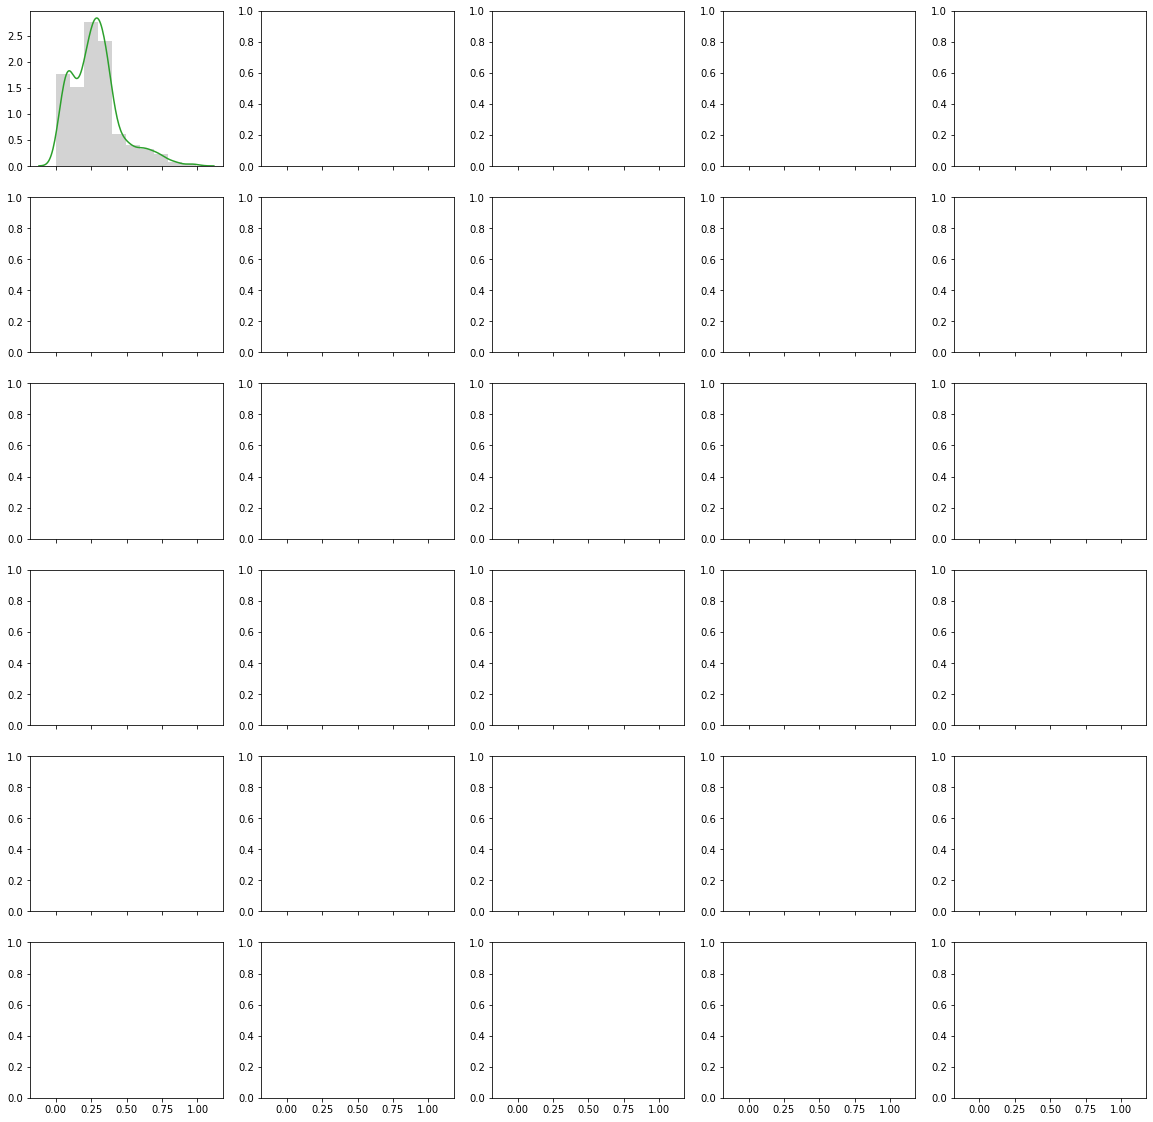

In [ ]:
fig, axs = plt.subplots(6, 5, figsize=(20, 20), sharex=True)

n_comps = 3
hellinger_distance_table[n_comps] = []

for i in range(6):
    for j in range(5):
        num = i*5 + j
        ax = axs[i][j]

        ax.hist(df.loc[df['SystemCodeNumber'] == lot_list[num], '%'].values, \
                    density=True, facecolor='lightgray', label='Histogram')
        
        # show me that ubvi goodness
        x_pred = np.arange(0, 1, 0.01)
        y_pred = np.array([qs[num](x) for x in list(x_pred)]).flatten()
        ax.plot(x_pred, y_pred, label='UBVI')
        
        sns.kdeplot(df.loc[df['SystemCodeNumber'] == lot_list[num], '%'], ax=ax, \
                    label='KDE')
        ax.set_ylabel('')

        # use this opportunity to calcualte divergence
        hellinger_distance_table[n_comps].append((num, hellinger_distance(fs[num], qs[num])))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, prop={'size': 22})

# fig.tight_layout()

# plt.suptitle('UBVI vs KDE', fontsize=40)

In [ ]:
hellinger_distance_table

# Calculate KL-Divergence between KDE and Q

In [ ]:
stats.entropy(fs[0], qs[0])

In [ ]:
def hellinger_distance(f, g):
  inner = lambda x: (np.sqrt(f(x)) - np.sqrt(g(x)))**2

  return scipy.integrate.quad(inner, -np.inf, np.inf)

hellinger_distance(fs[0], qs[0])

# Code for generating figures

In [ ]:
ip_samples = dict()

bigNs = [500, 1000, 5000, 10000, 25000, 50000, 100000]
for bigN in tqdm(bigNs):
  ip_samples[bigN] = []
  for j in range(100):
    ip_samples[bigN].append(norm_innerproduct_closed(1, 1.2, 2, 1.4, N=bigN))

ip_sample_x = bigNs
ip_sample_y = []
for bigN in bigNs:
  runs = np.array(ip_samples[bigN])
  ip_sample_y.append(np.std(runs))
  print(np.mean(runs), np.std(runs))

ax = sns.lineplot(ip_sample_x, ip_sample_y)
ax.set(xscale='log')
plt.title('<h, h\'> Sensitivity to Sample Count')
ax.set(xlabel='Sample Count', ylabel='<h, h\'> standard deviation')
plt.axvline(x=50000, color='r', ls='--')